<h1 align="center">
<img src="https://drive.google.com/uc?export=view&id=1_ZkE3dnYg9KykzdZE6lIK2s_q_nbiKk_" width="160" height="160">
</h1>
<h1 align="center">Statistical Learning - 255381</h1>
<h3 align="center">Dr. Hoda Mohammadzade</h3>
<h5 align="center">Sharif University of Technology<br/>Electrical Engineering Department<br/>  Spring 2022</h5>

---

# Project - Phase_2a
<h4 align="center">Vahid Pourakbar     400205511</h4>


---
---

In [20]:
%reset -f
import numpy as np
# import matplotlib.pyplot as plt
from sklearn import preprocessing, model_selection
from sklearn.decomposition import PCA
# from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV

import sys
sys.path.append(r'../')
import pickle
from utils import *
# from utils import dataset, max_length, pre_processing_dataset, zero_padding_data
# from utils import classification_report_plot, confusion_matrix_plot
import warnings
warnings.filterwarnings('ignore')

In [2]:
with open(r'..\Phase_1\Phase1_train.npy', 'rb') as f:
    X = np.load(f)
    Y = np.load(f)
    I = np.load(f)
with open(r'..\Phase_1\Phase1_test.npy', 'rb') as f:
    X_test = np.load(f, allow_pickle=True)
    Y_test = np.load(f)
    I_test = np.load(f)

X_train = X.copy()
Y_train = Y.copy()
I_train = I.copy()

In [3]:
audio_max_len = max(max_length(X_train), max_length(X_test))

In [4]:
X_train.shape, X_test.shape

((2000, 10504), (500, 10504))

In [5]:
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# X_test = preprocessing.StandardScaler().fit_transform(X_test)
# model = make_pipeline(StandardScaler(), LinearRegression())

pca = PCA()
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

models = []
models.append(('LogR', LogisticRegression(solver='newton-cg')))
models.append(('LDA', LDA()))
# models.append(('QDA', QDA()))  UserWarning: Variables are collinear
#    warnings.warn("Variables are collinear")
#  mean and std of the cv accuracies for QDA: 0.113500 (0.016439)
models.append(('KNN', KNeighborsClassifier()))
models.append(('DTC', DecisionTreeClassifier()))
models.append(('SVM', SVC()))
models.append(('RFC', RFC()))

In [6]:
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, shuffle=True) 
    cross_val_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
    print(f'mean and std of the cross_val accuracies for {name}: {cross_val_results.mean()},\t{cross_val_results.std()}')

mean and std of the cross_val accuracies for LogR: 0.255,	0.022472205054244236
mean and std of the cross_val accuracies for LDA: 0.0965,	0.016132265804901676
mean and std of the cross_val accuracies for KNN: 0.209,	0.029051678092667902
mean and std of the cross_val accuracies for DTC: 0.1415,	0.013793114224133719
mean and std of the cross_val accuracies for SVM: 0.23500000000000001,	0.01987460691435179
mean and std of the cross_val accuracies for RFC: 0.2185,	0.02110094784600919


In [7]:
for name, model in models:
    print(f'\tmodel = {name}:')
    train_accuracy, val_accuracy, test_accuracy = [], [], []
    kfold = model_selection.KFold(n_splits=5, shuffle=True) 
    for train_index, test_index in kfold.split(X_train):
        _model = model.fit(X_train[train_index], Y_train[train_index])
        train_accuracy.append(accuracy_score(Y_train[train_index], _model.predict(X_train[train_index])))
        val_accuracy.append(accuracy_score(Y_train[test_index], _model.predict(X_train[test_index])))
        test_accuracy.append(accuracy_score(Y_test, _model.predict(X_test)))
    msg = 'average accuracy of\t'
    msg += 'train = {:.5f} \t'.format(sum(train_accuracy)/len(train_accuracy))
    msg += 'validation = {:.5f}\t'.format(sum(val_accuracy)/len(val_accuracy))
    msg += 'test = {:.5f}\t'.format(sum(test_accuracy)/len(test_accuracy))
    print(msg)

	model = LogR:
average accuracy of	train = 0.99988  	validation = 0.24100	test = 0.24720	
	model = LDA:
average accuracy of	train = 0.82800  	validation = 0.10300	test = 0.10080	
	model = KNN:
average accuracy of	train = 0.41938  	validation = 0.19400	test = 0.18480	
	model = DTC:
average accuracy of	train = 1.00000  	validation = 0.18000	test = 0.12960	
	model = SVM:
average accuracy of	train = 0.46513  	validation = 0.22300	test = 0.23000	
	model = RFC:
average accuracy of	train = 1.00000  	validation = 0.22300	test = 0.16000	


In [11]:
for name, model in models:
    _model = model.fit(X_train, Y_train)
    print(f'model = {name}: train accuracy = {accuracy_score(Y_train, _model.predict(X_train))}', end='\t')
    print(f'test accuracy = {accuracy_score(Y_test, _model.predict(X_test))}')

model = LogR: train accuracy = 0.9995	test accuracy = 0.27
model = LDA: train accuracy = 0.6825	test accuracy = 0.106
model = KNN: train accuracy = 0.4275	test accuracy = 0.19
model = DTC: train accuracy = 1.0	test accuracy = 0.13
model = SVM: train accuracy = 0.463	test accuracy = 0.25
model = RFC: train accuracy = 1.0	test accuracy = 0.162


In [12]:
# performing SVM with grid search
print('Start GridSearch to optimize hyperparameters of SVM, which already performed well with defualt parameters\n')
# parameters = {'kernel':('linear', 'rbf', 'sigmoid'), 'C':(100,10,1,0.25,0.5),'gamma': (0.0001,0.001,'auto', 0.01, 1)}
parameters = {'C':(100,10,1,0.25,0.5),'gamma': (0.0001,0.001,'auto', 0.01, 1)} # 'linear', 'sigmoid' 
clf_GS = GridSearchCV(estimator=SVC(kernel='rbf'), param_grid=parameters, scoring='accuracy', cv=5)
clf_GS.fit(X_train,Y_train)
print(f'The best parameters for SVM accuracy: {clf_GS.best_params_}, with score = {clf_GS.best_score_}')

Start GridSearch to optimize hyperparameters of SVM, which already performed well with defualt parameters

The best parameters for SVM accuracy: {'C': 10, 'gamma': 0.0001}, with score = 0.261


In [13]:
_model = SVC(C=10, gamma=0.0001, kernel='rbf').fit(X_train, Y_train)
print(f'model = SVM: train accuracy = {accuracy_score(Y_train, _model.predict(X_train))}',end='\t')
print(f'test accuracy = {accuracy_score(Y_test, _model.predict(X_test))}')

model = SVM: train accuracy = 0.7235	test accuracy = 0.264


In [14]:
# performing LogR with grid search
print('Start GridSearch to optimize hyperparameters of LOGR, which already performed well with defualt parameters\n')
parameters = {'C':(10,1,0.25,0.5),'solver': ('newton-cg', 'lbfgs')} #'sag', 'liblinear', 'saga'
clf_GS = GridSearchCV(estimator=LogisticRegression(), param_grid=parameters, scoring='accuracy', cv=5)
clf_GS.fit(X_train,Y_train)
print(f'The best parameters for LogR accuracy: {clf_GS.best_params_}, with score = {clf_GS.best_score_}')

Start GridSearch to optimize hyperparameters of LOGR, which already performed well with defualt parameters

The best parameters for LogR accuracy: {'C': 0.5, 'solver': 'lbfgs'}, with score = 0.2595


In [15]:
_model = LogisticRegression(C=0.5, solver='lbfgs').fit(X_train, Y_train)
print(f'model = LogR: train accuracy = {accuracy_score(Y_train, _model.predict(X_train))}',end='\t')
print(f'test accuracy = {accuracy_score(Y_test, _model.predict(X_test))}')

model = LogR: train accuracy = 0.94	test accuracy = 0.284


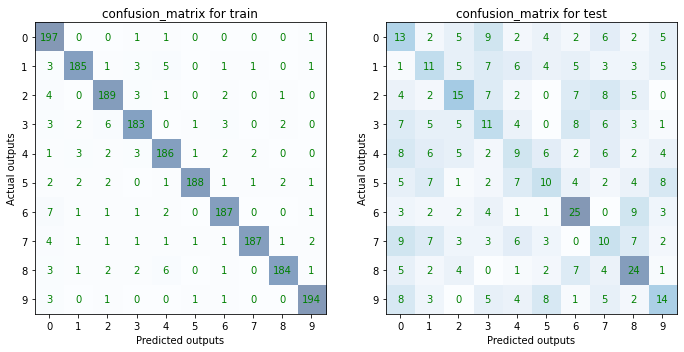

In [16]:
cm = [confusion_matrix(Y_train, _model.predict(X_train))]
cm.append(confusion_matrix(Y_test, _model.predict(X_test)))
confusion_matrix_plot(cm)

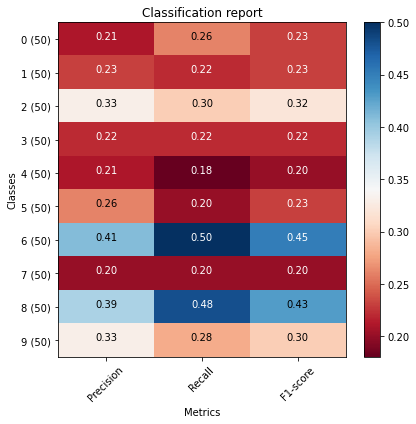

    accuracy                           0.28       500
   macro avg       0.28      0.28      0.28       500
weighted avg       0.28      0.28      0.28       500



In [17]:
classification_report_plot(classification_report(Y_test, _model.predict(X_test)))

## Part B

In [18]:
with open('Model_Phase2a.pkl', 'wb') as file:
    pickle.dump(_model, file)

## Part C

In [19]:
def Predict_Phase1(path_data=r'..\Dataset\test', path_model='Model_Phase2a.pkl'):
    with open(path_model , 'rb') as f:
        loaded_model = pickle.load(f)
    
    X2a_test, _, _, _ = dataset(path_data)
    audio_data_test = pre_processing_dataset(X2a_test)
    max_len = max(audio_max_len, max_length(audio_data_test))
    output_audio_test = np.asarray(zero_padding_data(audio_data_test, max_len))

    _X2a_test = scaler.transform(output_audio_test)
    _X2a_test = pca.transform(_X2a_test)

    with open('phase2a_predicted.npy', 'wb') as f:
        np.save(f, loaded_model.predict(_X2a_test))
    # print(f'test accuracy = {accuracy_score(Y_test, loaded_model.predict(_X2a_test))}')


Predict_Phase1() 